# 1 Computer vision libraries in PyTorch

* `torchvision` - base domain library for computer vision in PyTorch
* `torchvision` - Core computer vision library providing datasets, transforms, models, and utilities.
* `torch.nn` - Fundamental building blocks for neural networks, including layers, activation functions, and loss functions.
* `torch.optim` - Optimization algorithms for training neural networks, such as SGD, Adam, and RMSprop.
* `torch.utils.data` - Tools for loading and processing datasets, including `DataLoader` for efficient batching and shuffling. 
* `torch.autograd` - Automatic differentiation engine for computing gradients, enabling backpropagation for training neural networks.

In [194]:
# import PyTorch
import torch
from torch import nn

# import torchvision
import torchvision
from torchvision.transforms import v2 as transforms
from torchvision.transforms.v2 import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Check versions
print(torch.__version__)
print(torchvision.__version__)

2.4.0+cu121
0.19.0+cu121


##  1. Getting the dataset

The dataset we will use is the MNIST dataset. It is a dataset of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images. We will use the PyTorch `torchvision` module to download the dataset and create a `DataLoader` object for the training and test sets.

In [195]:
# Setup training data
from torchvision import datasets
transforms = transforms.Compose([
    transforms.ToTensor()
])
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms,
    target_transform=None
)

# Setup test data
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms,
    target_transform=None
)

/media/etudiant/New D/PyTorchSRC/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [196]:
len(train_data), len(test_data)

(60000, 10000)

In [197]:
# See the first training data
image, label = train_data[0]
print(image.shape, label)

torch.Size([1, 28, 28]) 9


In [198]:
class_names = train_data.classes
print(class_names)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [199]:
class_to_idx = train_data.class_to_idx # class to index
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [200]:
train_data.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

### 1.2 Visializing our data

torch.Size([1, 28, 28]) 4


Text(0.5, 1.0, 'Label: 4 - Coat')

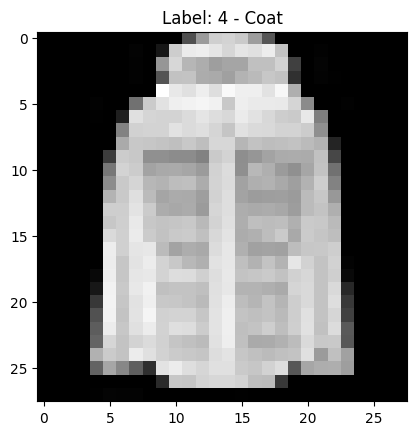

In [201]:
import random
import matplotlib.pyplot as plt
random_image = random.choice(range(len(train_data)))
image, label = train_data[random_image]
print(image.shape, label)
plt.imshow(image.squeeze(), cmap="gray")
plt.title(f"Label: {label} - {class_names[label]}")

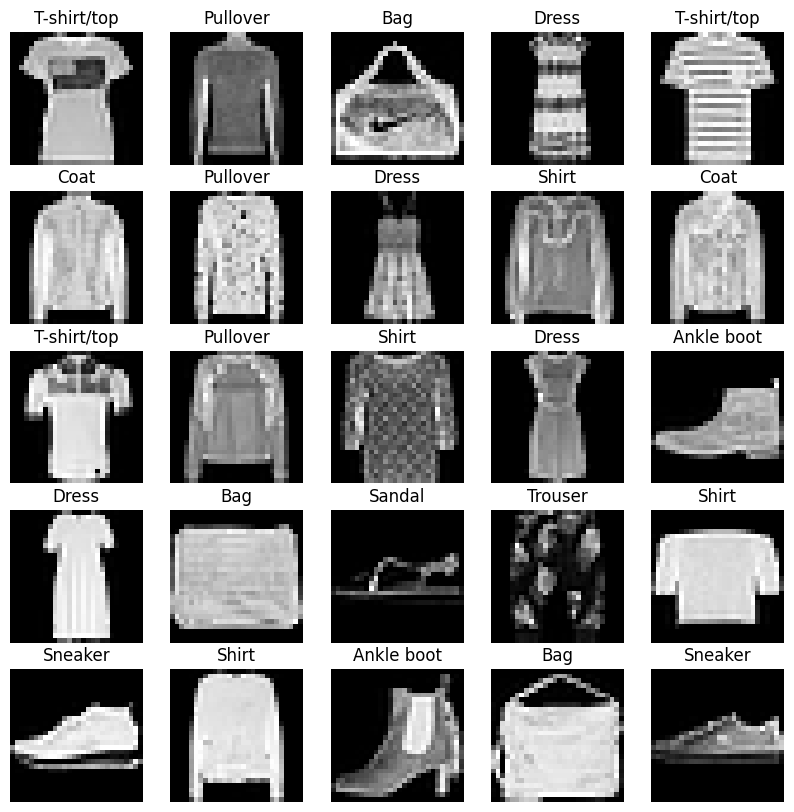

In [202]:
# Plot multiple images
figure = plt.figure(figsize=(10, 10))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = random.choice(range(len(train_data)))
    image, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(f"{class_names[label]}")
    plt.axis("off")
    plt.imshow(image.squeeze(), cmap="gray")
plt.show()


In [203]:
train_data, test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: Compose(    ToTensor()),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: Compose(    ToTensor()))

## 2. Prepare DataLoader

In [204]:
from torch.utils.data import DataLoader

# Setup batch size hyperparameter
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True) 

test_dataloader = DataLoader(dataset=test_data,
                         batch_size=BATCH_SIZE,
                          shuffle=False)

In [205]:
len(train_dataloader), len(test_dataloader)

(1875, 313)

In [206]:
len(train_data) / 32, len(test_data) / 32

(1875.0, 312.5)

In [207]:
train_dataloader.__len__()

1875

In [208]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

## 3. Model 0: Build a baseline model

In [209]:
# Create the flatten layer
flatten_model = nn.Flatten()

# Get a simple sample
x = train_features_batch[0]

# Flatten the sample
output = flatten_model(x)
x.shape, output.shape

(torch.Size([1, 28, 28]), torch.Size([1, 784]))

In [210]:
class FashionMNISTModelV0(nn.Module):
    def __init__(self,
                 input_size: int,
                 hidden_units: int,
                 output_shape: int):
        super(FashionMNISTModelV0, self).__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_size,
                      out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,
                      out_features=output_shape)
        )
    
    def forward(self, x):
        return self.layer_stack(x)
    

In [211]:
model_0 = FashionMNISTModelV0(input_size=28*28,
                                hidden_units=128,
                                output_shape=10)
model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

### 3.1 Setup the loss, optimizer and evaluation metrics

In [212]:
# Setup the loss function
loss_fn = nn.CrossEntropyLoss()

# Setup the optimizer
from torch.optim import Adam
optimizer = Adam(params=model_0.parameters(), lr=1e-3)

# Setup the evaluation metric
from torchmetrics import Accuracy, Precision, Recall
accuracy = Accuracy(task="multiclass", num_classes=10)
precision = Precision(task="multiclass", num_classes=10)
recall = Recall(task="multiclass", num_classes=10)


In [213]:
from pathlib import Path
import requests

if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download...")
else:
    print("Downloading helper_function.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-leaning/main/helper_function.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

helper_functions.py already exists, skipping download...


### 3.2 Create a function to time our experiments

Machine learning is very experimental. 

Two of the main things we'll often want to track are:
- How long our experiments have taken
- The results of our experiments


In [214]:
from timeit import default_timer as timer
def print_train_time(start:float,
                     end:float,
                     device:torch.device=None) -> float:
    """Prints difference between start and end time.

    Args:
        start (float): the start time.
        end (float): the end time.
        device (torch.device, optional): The device it's running on. Defaults to None.

    Returns:
        float: The difference between start and end time.
    """

    train_time = end - start
    print(f"Training time on {device}: {train_time:.3f} seconds")
    return train_time

In [215]:
start_time = timer()

# Setup the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

end_time = timer()

print_train_time(start=start_time, end=end_time, device=device)

Training time on cpu: 0.000 seconds


0.00012815900845453143

### 3.3 Creating a training loop and training the model on batches of data

1. Loop through epochs
2. Loop through the training data, performs training steps, calculate the train loss per epoch
3. Loop through the test data, performs evaluation steps, calculate the test loss per epoch
4. Print the train and test loss per epoch
5. Time it all

In [216]:
# Import tqdm for progress bars
from tqdm.auto import tqdm

train_time_start = timer()

# Set the number of epochs
EPOCHS = 5

# Create the training loop
for epoch in tqdm(range(EPOCHS)):
    # Setup the model for training
    model_0.train()
    
    # Setup the training loop
    for batch_idx, (data, target) in enumerate(train_dataloader):
        # Move the data to the device
        data, target = data.to(device), target.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model_0(data)
        
        # Calculate the loss
        loss = loss_fn(output, target)
        
        # Backward pass
        loss.backward()
        
        # Optimize the weights
        optimizer.step()

    # Set the model to evaluation mode
    model_0.eval()
    with torch.inference_mode():
        for data, target in test_dataloader:
            data, target = data.to(device), target.to(device)
            output = model_0(data)

            # 1. Calculate the loss
            loss = loss_fn(output, target)

            # 2. Update the metrics
            accuracy.update(output, target)
            precision.update(output, target)
            recall.update(output, target)
        
    # Print the training and test metrics
    print(f"Epoch: {epoch + 1}/{EPOCHS}")
    print(f"Loss: {loss.item():.4f}")
    print(f"Accuracy: {accuracy.compute():.4f}")
    print(f"Precision: {precision.compute():.4f}")
    print(f"Recall: {recall.compute():.4f}")
    print("----")

train_time_end = timer()
total_train_time_model_0 = print_train_time(start=train_time_start, end=train_time_end, device=device)

 20%|██        | 1/5 [00:06<00:26,  6.62s/it]

Epoch: 1/5
Loss: 0.2095
Accuracy: 0.8342
Precision: 0.8342
Recall: 0.8342
----


 40%|████      | 2/5 [00:15<00:24,  8.05s/it]

Epoch: 2/5
Loss: 0.2618
Accuracy: 0.8449
Precision: 0.8449
Recall: 0.8449
----


 60%|██████    | 3/5 [00:25<00:17,  8.95s/it]

Epoch: 3/5
Loss: 0.1481
Accuracy: 0.8521
Precision: 0.8521
Recall: 0.8521
----


 80%|████████  | 4/5 [00:33<00:08,  8.35s/it]

Epoch: 4/5
Loss: 0.2255
Accuracy: 0.8557
Precision: 0.8557
Recall: 0.8557
----


100%|██████████| 5/5 [00:42<00:00,  8.55s/it]

Epoch: 5/5
Loss: 0.1216
Accuracy: 0.8599
Precision: 0.8599
Recall: 0.8599
----
Training time on cpu: 42.765 seconds


## 4. Make predictinons and get Model 0 results

In [217]:
import torchmetrics

def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy: torchmetrics.Accuracy,
               precision: torchmetrics.Precision,
               recall: torchmetrics.Recall,
               device: torch.device) -> dict:
    """Returns a dictionary containing the results of the evaluation.

    Args:
        model (torch.nn.Module): The model to evaluate.
        data_loader (torch.utils.data.DataLoader): The data loader to evaluate the model on.
        loss_fn (torch.nn.Module): The loss function to use.
        accuracy (torchmetrics.Accuracy): The accuracy metric.
        precision (torchmetrics.Precision): The precision metric.
        recall (torchmetrics.Recall): The recall metric.
        device (torch.device): The device to run the evaluation on.

    Returns:
        dict: A dictionary containing the model name, loss, accuracy, precision and recall.
    """

    loss, acc, prec, rec = 0.0, 0.0, 0.0, 0.0

    # Set the model to evaluation mode
    model.eval()

    with torch.inference_mode():
        for data, target in tqdm(data_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)

            # 1. Calculate the loss
            loss += loss_fn(output, target)

            # 2. Update the metrics
            accuracy.update(output, target)
            precision.update(output, target)
            recall.update(output, target)

            acc += accuracy.compute()
            prec += precision.compute()
            rec += recall.compute()

        # Scale the metrics to find the average loss/accuracy/precision/recall
        loss /= len(data_loader)
        acc /= len(data_loader)
        prec /= len(data_loader)
        rec /= len(data_loader)


    return {
        "model_name": model.__class__.__name__,
        "loss": loss.item(),
        "accuracy": acc.item(),
        "precision": prec.item(),
        "recall": rec.item()
    }

In [218]:
# Calculate model 0 results on test data
accuracy.reset()
precision.reset()
recall.reset()

model_0_results = eval_model(model=model_0,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy=accuracy,
                             precision=precision,
                             recall=recall,
                             device=device)

100%|██████████| 313/313 [00:01<00:00, 266.01it/s]


In [219]:
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'loss': 0.3586380183696747,
 'accuracy': 0.8805142045021057,
 'precision': 0.8805142045021057,
 'recall': 0.8805142045021057}

## 5. Make agnostic to device

In [220]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## 6. Model 1: Building a better model with non-linear activation functions

We learn about the pilar of non-linear activation functions and how they can help our model learn more complex patterns in the data.



In [221]:
# Create a model with non-linear and linear layers
class FashionMNISTModelV1(nn.Module):
    """A simple model for FashionMNIST.

    Args:
        nn (nn.Module): The PyTorch neural network module.

    Returns:
        nn.Module: The FashionMNIST model.
    """
    def __init__(self,
                 input_shape: int,
                 output_shape: int,
                 hidden_units: int):
        super(FashionMNISTModelV1, self).__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape,
                      out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,
                      out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,
                      out_features=output_shape),
            nn.ReLU()
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass of the model.

        Args:
            x (torch.Tensor): The input data.

        Returns:
            torch.Tensor: The output of the model.
        """
        return self.layer_stack(x)

In [222]:
# Create an instance of the model
model_1 = FashionMNISTModelV1(input_shape=28*28,
                               output_shape=len(class_names),
                               hidden_units=128)

next(model_1.parameters()).device

device(type='cpu')

In [223]:
model_1.parameters

<bound method Module.parameters of FashionMNISTModelV1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=10, bias=True)
    (6): ReLU()
  )
)>

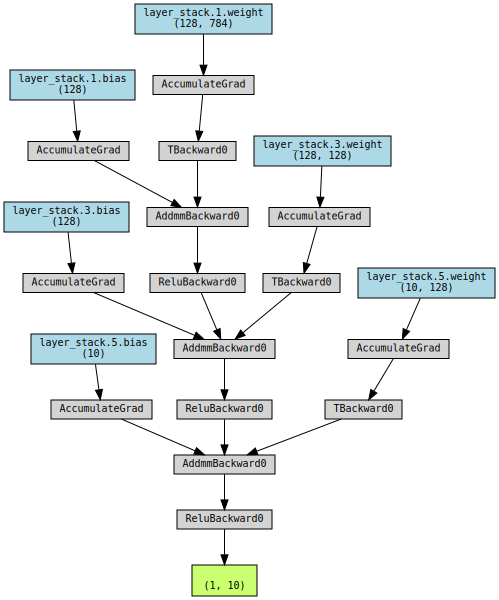

In [224]:
# Plot the model
from torchviz import make_dot
x = torch.randn(1, 28*28).to(device)
make_dot(model_1(x), params=dict(model_1.named_parameters()))


### 6.1 Setup loss, optimizer, and evaluation metrics

In [225]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), 
                 lr=1e-3)

accuracy = Accuracy(task="multiclass", num_classes=len(class_names))

### 6.2 FUnctionnizing the training and testing loop

Let'S create a function to train and evaluate the model

* Training loop - `train_step()`
* Testing step - `test_step()`

In [247]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> None:
    
    """Performs a training with model trying to learn on data_loader.
    """

    train_loss, train_acc = 0.0, 0.0

    # Set the model to training mode
    model.train()
    
    # Iterate over the training data
    for batch, (data, target) in enumerate(train_dataloader):
        # Move the data to the device
        data, target = data.to(device), target.to(device)

        # Forward pass
        output = model(data)

        # Calculate the loss and accuracy (per batch)
        loss = loss_fn(output, target)
        accuracy.update(output, target)
        train_loss += loss.item()
        train_acc = accuracy.compute()
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Calculate the loss
        loss = loss_fn(output, target)
        
        # Backward pass
        loss.backward()
        
        # Optimize the weights
        optimizer.step()

        # Print out what's happening
        if batch % 400 == 0:
            print(f"Batch {batch} Loss: {loss.item()} Accuracy: {accuracy.compute()}")
        
    # Print out the final training loss
    print(f"Training loss: {train_loss / len(data_loader)}")
    print(f"Training accuracy: {train_acc}")


In [227]:
def test_step(model:nn.Module,
              data_loader:torch.utils.data.DataLoader,
              loss_fn:torch.nn.Module,
              accuracy:torchmetrics.Accuracy,
              device:torch.device) -> None:
    """Performs a test step on the model.
    """

    test_loss, test_acc = 0.0, 0.0

    # Set the model to evaluation mode
    model.eval()

    with torch.inference_mode():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # 1. Calculate the loss
            loss = loss_fn(output, target)

            # 2. Update the metrics
            accuracy.update(output, target)

            test_loss += loss.item()
            test_acc = accuracy.compute()

        # Print out the final test loss
        print(f"Test loss: {test_loss / len(data_loader)}")
        print(f"Test accuracy: {test_acc}")

In [228]:
# Measure the time it takes to train the model
train_time_start = timer()

# Set the number of epochs
EPOCHS = 5

# Train the model
for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch: {epoch + 1}/{EPOCHS}")
    train_step(model=model_1,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               device=device)
    
    test_step(model=model_1,
                data_loader=test_dataloader,
                loss_fn=loss_fn,
                accuracy=accuracy,
                device=device)
    
    print("----")

train_time_end = timer()

total_train_time_model_1 = print_train_time(start=train_time_start, end=train_time_end, device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1/5
Batch 0 Loss: 2.3033666610717773 Accuracy: 0.125
Batch 100 Loss: 2.2911248207092285 Accuracy: 0.10148514807224274
Batch 200 Loss: 2.307274580001831 Accuracy: 0.10401119291782379
Batch 300 Loss: 2.2866334915161133 Accuracy: 0.11472176015377045
Batch 400 Loss: 2.2968039512634277 Accuracy: 0.12951995432376862
Batch 500 Loss: 2.288864850997925 Accuracy: 0.14814122021198273
Batch 600 Loss: 2.268981456756592 Accuracy: 0.16399750113487244
Batch 700 Loss: 2.251068115234375 Accuracy: 0.1789853721857071
Batch 800 Loss: 2.2847542762756348 Accuracy: 0.19284488260746002
Batch 900 Loss: 2.227459192276001 Accuracy: 0.204078808426857
Batch 1000 Loss: 2.2942841053009033 Accuracy: 0.2124750316143036
Batch 1100 Loss: 2.2192764282226562 Accuracy: 0.220566526055336
Batch 1200 Loss: 2.257067918777466 Accuracy: 0.22816923260688782
Batch 1300 Loss: 2.2237088680267334 Accuracy: 0.2343149483203888
Batch 1400 Loss: 2.2194972038269043 Accuracy: 0.2388472557067871
Batch 1500 Loss: 2.167292356491089 Accu

 20%|██        | 1/5 [00:09<00:39,  9.83s/it]

Test loss: 2.182039234965754
Test accuracy: 0.2660142779350281
----
Epoch: 2/5
Batch 0 Loss: 2.1435348987579346 Accuracy: 0.2660498023033142
Batch 100 Loss: 2.138864278793335 Accuracy: 0.2685028314590454
Batch 200 Loss: 2.1014883518218994 Accuracy: 0.27034488320350647
Batch 300 Loss: 2.2201650142669678 Accuracy: 0.2720514237880707
Batch 400 Loss: 2.1721677780151367 Accuracy: 0.27342090010643005
Batch 500 Loss: 2.1494033336639404 Accuracy: 0.2747814655303955
Batch 600 Loss: 2.0215377807617188 Accuracy: 0.27566343545913696
Batch 700 Loss: 2.0715699195861816 Accuracy: 0.27681970596313477
Batch 800 Loss: 2.1553094387054443 Accuracy: 0.27817049622535706
Batch 900 Loss: 2.175123453140259 Accuracy: 0.27932247519493103
Batch 1000 Loss: 2.1813628673553467 Accuracy: 0.28046104311943054
Batch 1100 Loss: 2.0235486030578613 Accuracy: 0.2817964255809784
Batch 1200 Loss: 2.099677562713623 Accuracy: 0.2830714285373688
Batch 1300 Loss: 1.9794648885726929 Accuracy: 0.2841837406158447
Batch 1400 Loss: 1.

 40%|████      | 2/5 [00:20<00:31, 10.35s/it]

Test loss: 1.9436213075162503
Test accuracy: 0.29773572087287903
----
Epoch: 3/5
Batch 0 Loss: 2.031404495239258 Accuracy: 0.2977319359779358
Batch 100 Loss: 1.9673614501953125 Accuracy: 0.29949313402175903
Batch 200 Loss: 1.7958804368972778 Accuracy: 0.30157342553138733
Batch 300 Loss: 2.261046886444092 Accuracy: 0.3034377694129944
Batch 400 Loss: 1.8002079725265503 Accuracy: 0.30540725588798523
Batch 500 Loss: 1.8663439750671387 Accuracy: 0.3072574734687805
Batch 600 Loss: 1.8209614753723145 Accuracy: 0.3092029094696045
Batch 700 Loss: 1.8943936824798584 Accuracy: 0.3108192980289459
Batch 800 Loss: 1.6596767902374268 Accuracy: 0.31228870153427124
Batch 900 Loss: 1.9790319204330444 Accuracy: 0.31406369805336
Batch 1000 Loss: 1.8195185661315918 Accuracy: 0.3158423900604248
Batch 1100 Loss: 1.8148123025894165 Accuracy: 0.3173849582672119
Batch 1200 Loss: 1.6840074062347412 Accuracy: 0.3188609778881073
Batch 1300 Loss: 1.8785845041275024 Accuracy: 0.3204115927219391
Batch 1400 Loss: 1.68

 60%|██████    | 3/5 [00:29<00:19,  9.68s/it]

Test loss: 1.745301363567194
Test accuracy: 0.33176189661026
----
Epoch: 4/5
Batch 0 Loss: 1.7678813934326172 Accuracy: 0.3317732512950897
Batch 100 Loss: 1.5749245882034302 Accuracy: 0.33307382464408875
Batch 200 Loss: 1.6186368465423584 Accuracy: 0.33446070551872253
Batch 300 Loss: 1.7782173156738281 Accuracy: 0.33591189980506897
Batch 400 Loss: 1.6445655822753906 Accuracy: 0.33698931336402893
Batch 500 Loss: 1.5751842260360718 Accuracy: 0.3380362093448639
Batch 600 Loss: 1.9609843492507935 Accuracy: 0.33886629343032837
Batch 700 Loss: 1.9375009536743164 Accuracy: 0.3399445712566376
Batch 800 Loss: 1.4277310371398926 Accuracy: 0.340951144695282
Batch 900 Loss: 1.755516529083252 Accuracy: 0.3421568274497986
Batch 1000 Loss: 1.853339672088623 Accuracy: 0.343289315700531
Batch 1100 Loss: 1.4410984516143799 Accuracy: 0.34424951672554016
Batch 1200 Loss: 1.7418920993804932 Accuracy: 0.34533795714378357
Batch 1300 Loss: 1.3469315767288208 Accuracy: 0.3461165428161621
Batch 1400 Loss: 1.833

 80%|████████  | 4/5 [00:38<00:09,  9.49s/it]

Test loss: 1.5796803715891732
Test accuracy: 0.35353928804397583
----
Epoch: 5/5
Batch 0 Loss: 1.6400138139724731 Accuracy: 0.35354530811309814
Batch 100 Loss: 1.5714389085769653 Accuracy: 0.35433849692344666
Batch 200 Loss: 1.5361522436141968 Accuracy: 0.355068564414978
Batch 300 Loss: 1.6613095998764038 Accuracy: 0.35567548871040344
Batch 400 Loss: 1.4159119129180908 Accuracy: 0.35661745071411133
Batch 500 Loss: 1.3906265497207642 Accuracy: 0.3573465049266815
Batch 600 Loss: 1.4741400480270386 Accuracy: 0.35825714468955994
Batch 700 Loss: 1.427647352218628 Accuracy: 0.35896995663642883
Batch 800 Loss: 1.5448800325393677 Accuracy: 0.35961222648620605
Batch 900 Loss: 1.6612303256988525 Accuracy: 0.3602929711341858
Batch 1000 Loss: 1.3635848760604858 Accuracy: 0.3610847592353821
Batch 1100 Loss: 1.4605371952056885 Accuracy: 0.3618065416812897
Batch 1200 Loss: 1.4426908493041992 Accuracy: 0.3623662292957306
Batch 1300 Loss: 1.71934974193573 Accuracy: 0.3631044030189514
Batch 1400 Loss: 1

100%|██████████| 5/5 [00:46<00:00,  9.39s/it]

Test loss: 1.4875363618040238
Test accuracy: 0.36866286396980286
----
Training time on cpu: 46.954 seconds


In [229]:
model_1_results = eval_model(model=model_1,
                                data_loader=test_dataloader,
                                loss_fn=loss_fn,
                                accuracy=accuracy,
                                precision=precision,
                                recall=recall,
                                device=device)

100%|██████████| 313/313 [00:01<00:00, 221.88it/s]


In [230]:
model_1_results

{'model_name': 'FashionMNISTModelV1',
 'loss': 1.487535834312439,
 'accuracy': 0.36959874629974365,
 'precision': 0.7408839464187622,
 'recall': 0.7408839464187622}

## Model 2: Building a CNN model

CNN's are also know as Convolutional Neural Networks. They are a type of neural network that are particularly good at learning patterns in images.

In [231]:
# Create a covolution neural network model
class FashionMNISTModelV2(nn.Module):
    """A simple model for FashionMNIST.

    Args:
        nn (nn.Module): The PyTorch neural network module.
    """
    def __init__(self,
                 input_shape: int,
                 output_shape: int,
                 hidden_units: int):
        super(FashionMNISTModelV2, self).__init__()
        
        self.conv_block_01 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                        out_channels=hidden_units,
                        kernel_size=3,
                        stride=1,
                        padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv_block_02 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=hidden_units*2),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units*2,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass of the model.

        Args:
            x (torch.Tensor): The input data.

        Returns:
            torch.Tensor: The output of the model.
        """
        x = self.conv_block_01(x)
        # print(f"Output shape after conv_block_01: {x.shape}")
        x = self.conv_block_02(x)
        # print(f"Output shape after conv_block_02: {x.shape}")
        x = self.classifier(x)
        return x

In [232]:

image.shape

torch.Size([1, 28, 28])

In [233]:
# Create an instance of the model
model_2 = FashionMNISTModelV2(input_shape=1,
                               output_shape=len(class_names),
                               hidden_units=32)

In [234]:
model_2(image.unsqueeze(0)).shape

torch.Size([1, 10])

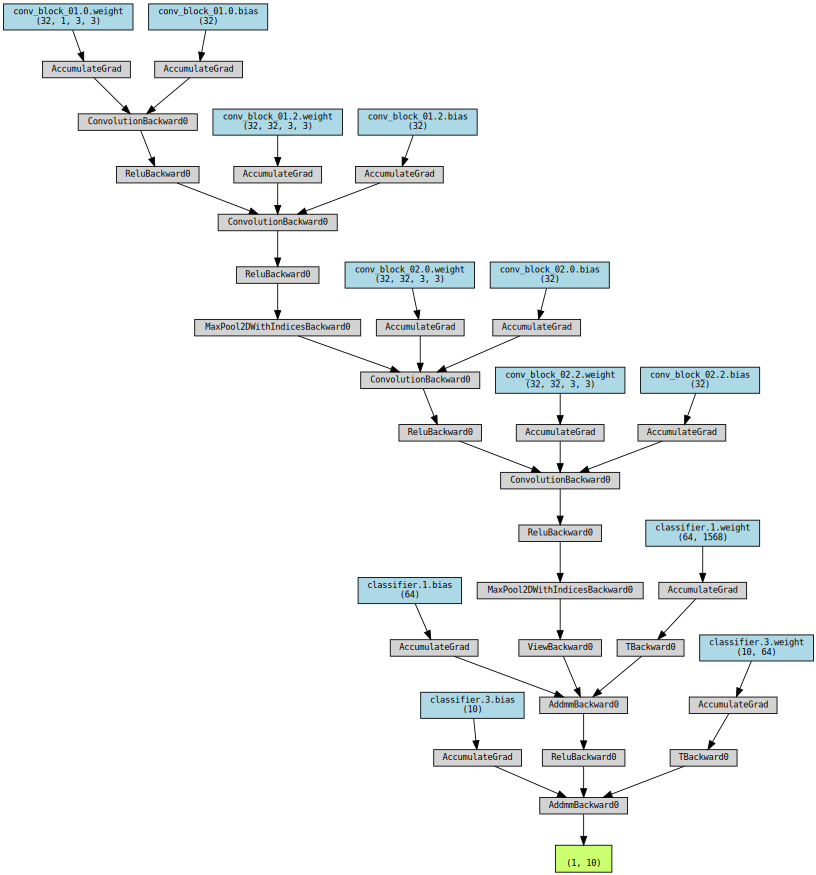

In [235]:
# plot the model
from torchviz import make_dot
x = torch.randn(1, 1, 28, 28).to(device)
make_dot(model_2(x), params=dict(model_2.named_parameters()))


## 7. Step through `Conv2d` layer

### 7.1 Stepping through ǹn.conv2d()`

see the documentation for `nn.Conv2d` [here](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)

In [236]:
# Create a batch of images
images = torch.randn(32, 3, 64, 64).to(device)
test_image = images[0]

print(f"Image batch shape: {images.shape}")
print(f"Test image shape: {test_image.shape}")
print(f"Test image: {test_image}")

Image batch shape: torch.Size([32, 3, 64, 64])
Test image shape: torch.Size([3, 64, 64])
Test image: tensor([[[ 1.4565e-01,  5.4543e-01,  6.2678e-01,  ..., -1.3336e+00,
           4.1009e-01,  9.6182e-01],
         [ 3.3141e-01,  1.1479e+00,  9.0086e-02,  ..., -1.5550e+00,
          -1.5679e+00, -4.9422e-01],
         [ 2.1524e-01, -4.3375e-02,  9.3979e-01,  ...,  8.5047e-01,
           2.4143e-01,  1.0797e-01],
         ...,
         [-4.0824e-01,  9.4441e-01, -3.0968e-01,  ..., -3.2286e-01,
           1.0134e+00, -1.8618e+00],
         [ 1.2158e+00, -4.1222e-01, -1.1530e+00,  ..., -2.7560e-01,
          -2.2720e-02, -3.6584e-01],
         [-5.5143e-01, -6.2831e-01,  8.6272e-01,  ...,  1.6128e+00,
           1.3694e-01,  5.4871e-01]],

        [[-3.2138e-03,  9.4663e-01, -9.9935e-01,  ..., -3.7861e-01,
           1.1254e+00, -9.3751e-01],
         [-9.0054e-01,  2.3706e-01,  3.1849e-01,  ..., -6.1769e-01,
           1.5885e-01,  1.1399e+00],
         [ 5.6521e-01, -1.8289e+00, -1.0462

In [237]:
# Create a convolutional layer
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=3,
                       stride=1,
                       padding=1)

# Pass the data through the convolutional layer

output = conv_layer(images[0])
output.shape

torch.Size([10, 64, 64])

### 7.2 Stepping through `nn.MaxPool2d`

In [238]:
test_image.shape

torch.Size([3, 64, 64])

In [239]:
# Create a max pooling layer
max_pool = nn.MaxPool2d(kernel_size=2)

# Pass the output through the max pooling layer
output = max_pool(test_image.unsqueeze(0))
output.shape

torch.Size([1, 3, 32, 32])

### 7.3 Setup a loss function and optimizer for `model_2`

In [240]:
import torchmetrics


loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2.parameters(), 
                             lr=1e-2)

accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=len(class_names))

### 7.4 Training and testing the model

In [241]:
# Measure time
train_start_time = timer()

# Train and test model
EPOCHS = 5
for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch: {epoch} \n--------")
    train_step(model=model_2,
               data_loader=train_dataloader,
               loss_fn=loss,
               optimizer=optimizer,
               device=device)
    
    test_step(model=model_2,
              data_loader=test_dataloader,
              loss_fn=loss,
              accuracy=accuracy,
              device=device)
    
train_time_end = timer()

total_train_time_model_2 = print_train_time(train_time_start, 
                                            train_time_end,
                                            device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 
--------
Batch 0 Loss: 2.302053451538086 Accuracy: 0.125
Batch 100 Loss: 0.652587354183197 Accuracy: 0.4820544421672821
Batch 200 Loss: 0.5679171085357666 Accuracy: 0.6106964945793152
Batch 300 Loss: 0.3377557396888733 Accuracy: 0.6668397188186646
Batch 400 Loss: 0.6864854097366333 Accuracy: 0.7004364132881165
Batch 500 Loss: 0.39195775985717773 Accuracy: 0.7244884967803955
Batch 600 Loss: 0.4007326662540436 Accuracy: 0.7410045862197876
Batch 700 Loss: 0.47105297446250916 Accuracy: 0.7536109089851379
Batch 800 Loss: 0.34294918179512024 Accuracy: 0.7643570303916931
Batch 900 Loss: 0.39223799109458923 Accuracy: 0.7723016142845154
Batch 1000 Loss: 0.460504949092865 Accuracy: 0.7790334820747375
Batch 1100 Loss: 0.3057282269001007 Accuracy: 0.7851101160049438
Batch 1200 Loss: 0.3895956873893738 Accuracy: 0.7894723415374756
Batch 1300 Loss: 0.4539731442928314 Accuracy: 0.7939325571060181
Batch 1400 Loss: 0.2335730940103531 Accuracy: 0.7984698414802551
Batch 1500 Loss: 0.51730757951

 20%|██        | 1/5 [00:45<03:01, 45.42s/it]

Test loss: 0.423217827805315
Test accuracy: 0.8162000179290771
Epoch: 1 
--------
Batch 0 Loss: 0.8816088438034058 Accuracy: 0.8161126375198364
Batch 100 Loss: 0.34977126121520996 Accuracy: 0.8177845478057861
Batch 200 Loss: 0.3883666396141052 Accuracy: 0.8198660016059875
Batch 300 Loss: 0.6428502202033997 Accuracy: 0.8214285969734192
Batch 400 Loss: 0.17726439237594604 Accuracy: 0.8231239318847656
Batch 500 Loss: 0.2501431703567505 Accuracy: 0.8247745037078857
Batch 600 Loss: 0.17985127866268158 Accuracy: 0.8259368538856506
Batch 700 Loss: 0.33520030975341797 Accuracy: 0.8275056481361389
Batch 800 Loss: 0.42007216811180115 Accuracy: 0.8286870718002319
Batch 900 Loss: 0.24825291335582733 Accuracy: 0.829650342464447
Batch 1000 Loss: 0.21232686936855316 Accuracy: 0.8307197690010071
Batch 1100 Loss: 0.24345937371253967 Accuracy: 0.8310685157775879
Batch 1200 Loss: 0.4346922039985657 Accuracy: 0.8319131135940552
Batch 1300 Loss: 0.29012617468833923 Accuracy: 0.8326913714408875
Batch 1400 L

 40%|████      | 2/5 [01:34<02:22, 47.55s/it]

Test loss: 0.35971810456853326
Test accuracy: 0.8385928869247437
Epoch: 2 
--------
Batch 0 Loss: 0.3450266122817993 Accuracy: 0.8386011719703674
Batch 100 Loss: 0.4695132374763489 Accuracy: 0.8393375873565674
Batch 200 Loss: 0.22327376902103424 Accuracy: 0.8399666547775269
Batch 300 Loss: 0.0924530178308487 Accuracy: 0.840408444404602
Batch 400 Loss: 0.17071646451950073 Accuracy: 0.8409691452980042
Batch 500 Loss: 0.39586398005485535 Accuracy: 0.8416543006896973
Batch 600 Loss: 0.3502272069454193 Accuracy: 0.8421673774719238
Batch 700 Loss: 0.17921575903892517 Accuracy: 0.8427157402038574
Batch 800 Loss: 0.5763360261917114 Accuracy: 0.8432368040084839
Batch 900 Loss: 0.3600900173187256 Accuracy: 0.8434953093528748
Batch 1000 Loss: 0.5626935362815857 Accuracy: 0.8439825177192688
Batch 1100 Loss: 0.21774116158485413 Accuracy: 0.8443605899810791
Batch 1200 Loss: 0.19234174489974976 Accuracy: 0.8447251319885254
Batch 1300 Loss: 0.21235181391239166 Accuracy: 0.8453136086463928
Batch 1400 L

 60%|██████    | 3/5 [02:23<01:36, 48.22s/it]

Test loss: 0.3590292586400486
Test accuracy: 0.8481952548027039
Epoch: 3 
--------
Batch 0 Loss: 0.38526415824890137 Accuracy: 0.8481897711753845
Batch 100 Loss: 0.37732458114624023 Accuracy: 0.8485405445098877
Batch 200 Loss: 0.28537634015083313 Accuracy: 0.8489225506782532
Batch 300 Loss: 0.22500213980674744 Accuracy: 0.8492797017097473
Batch 400 Loss: 0.329738974571228 Accuracy: 0.8496041893959045
Batch 500 Loss: 0.329141765832901 Accuracy: 0.8499593138694763
Batch 600 Loss: 0.3867589235305786 Accuracy: 0.850130021572113
Batch 700 Loss: 0.45076823234558105 Accuracy: 0.8504121899604797
Batch 800 Loss: 0.6514932513237 Accuracy: 0.8507291078567505
Batch 900 Loss: 0.1924886405467987 Accuracy: 0.8508784174919128
Batch 1000 Loss: 0.32085877656936646 Accuracy: 0.8511725664138794
Batch 1100 Loss: 0.3485051691532135 Accuracy: 0.8514426946640015
Batch 1200 Loss: 0.40926593542099 Accuracy: 0.8517059087753296
Batch 1300 Loss: 0.3510221838951111 Accuracy: 0.8519306182861328
Batch 1400 Loss: 0.16

 80%|████████  | 4/5 [03:14<00:49, 49.34s/it]

Test loss: 0.38582232016058393
Test accuracy: 0.8538749814033508
Epoch: 4 
--------
Batch 0 Loss: 0.6138643622398376 Accuracy: 0.8538738489151001
Batch 100 Loss: 0.4595842957496643 Accuracy: 0.8541761040687561
Batch 200 Loss: 0.2378985732793808 Accuracy: 0.8544785380363464
Batch 300 Loss: 0.307055801153183 Accuracy: 0.8547536134719849
Batch 400 Loss: 0.26502278447151184 Accuracy: 0.8550090193748474
Batch 500 Loss: 0.2405885010957718 Accuracy: 0.85523521900177
Batch 600 Loss: 0.32603737711906433 Accuracy: 0.8554866909980774
Batch 700 Loss: 0.33836397528648376 Accuracy: 0.8556435704231262
Batch 800 Loss: 0.20622117817401886 Accuracy: 0.8558233380317688
Batch 900 Loss: 0.4662882685661316 Accuracy: 0.8560641407966614
Batch 1000 Loss: 0.5079622268676758 Accuracy: 0.8561621904373169
Batch 1100 Loss: 0.2535821795463562 Accuracy: 0.8562677502632141
Batch 1200 Loss: 0.3051465153694153 Accuracy: 0.8564528822898865
Batch 1300 Loss: 0.14663298428058624 Accuracy: 0.8566591739654541
Batch 1400 Loss:

100%|██████████| 5/5 [04:10<00:00, 50.01s/it]

Test loss: 0.3480825811719742
Test accuracy: 0.8580828309059143
Training time on cpu: 298.619 seconds


In [242]:
# Get the results
model_2_results = eval_model(model=model_2,
                             data_loader=test_dataloader,
                             loss_fn=loss,
                             accuracy=accuracy,
                             precision=precision,
                             recall=recall,
                             device=device)

100%|██████████| 313/313 [00:03<00:00, 100.20it/s]


In [243]:
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'loss': 0.3480824828147888,
 'accuracy': 0.8582926392555237,
 'precision': 0.6966694593429565,
 'recall': 0.6966694593429565}

## 8. Compare model results and training times

In [244]:
import pandas as pd

results = pd.DataFrame([model_0_results, model_1_results, model_2_results])

results

,model_name,loss,accuracy,precision,recall
0,FashionMNISTModelV0,0.358638,0.880514,0.880514,0.880514
1,FashionMNISTModelV1,1.487536,0.369599,0.740884,0.740884
2,FashionMNISTModelV2,0.348082,0.858293,0.696669,0.696669


In [245]:
# Add training time to the results
results["train_time"] = [total_train_time_model_0, 
                         total_train_time_model_1,
                         total_train_time_model_2]


In [250]:
results

,model_name,loss,accuracy,precision,recall,train_time
0,FashionMNISTModelV0,0.358638,0.880514,0.880514,0.880514,42.764934
1,FashionMNISTModelV1,1.487536,0.369599,0.740884,0.740884,46.954134
2,FashionMNISTModelV2,0.348082,0.858293,0.696669,0.696669,298.619350


## 9. Make and evaluate random predictions with best model

In [270]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device) -> torch.stack:
    """Makes predictions on data using model.

    Args:
        model (torch.nn.Module): The model to make predictions with.
        data (list): The data to make predictions on.
        device (torch.device): The device to run the predictions on.

    Returns:
        torch.Stack: The predictions.
    """

    pred_probs = []

    # Send the model to the device
    model.to(device)

    # Set the model to evaluation mode
    model.eval()

    with torch.inference_mode():
        for image in data:
            image = image.unsqueeze(0).to(device)

            # Foward pass
            pred_logits = model(image)

            # Get the prediction probabilities
            pred_prob = torch.softmax(pred_logits, dim=1)

            # Append the prediction probabilities
            pred_probs.append(pred_prob.cpu())

    return torch.stack(pred_probs)

In [296]:
import random

test_samples = []
test_label = []

for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_label.append(label)

# View the forst sample shape
test_samples[0].shape

torch.Size([1, 28, 28])

Text(0.5, 1.0, 'Label: 4 - Coat')

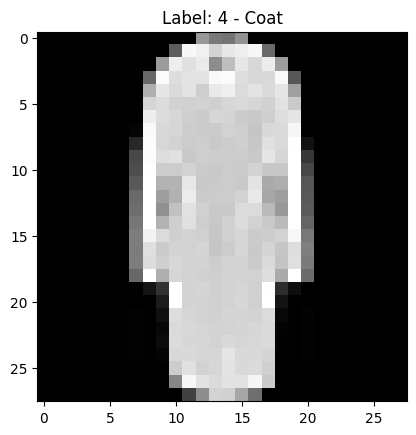

In [297]:
plt.imshow(test_samples[0].squeeze(), cmap="gray")
plt.title(f"Label: {test_label[0]} - {class_names[test_label[0]]}")

In [298]:
# Make predictions

pred_probs = make_predictions(model=model_2,
                              data=test_samples,
                              device=device)

pred_probs[:2]

tensor([[[1.2251e-03, 8.3123e-04, 5.1402e-03, 1.6584e-01, 8.1431e-01,
          2.7358e-07, 1.1926e-02, 4.4826e-08, 7.1078e-04, 1.2174e-05]],

        [[5.3700e-08, 8.7501e-15, 3.8777e-13, 1.2187e-10, 7.4710e-13,
          7.9607e-10, 7.7310e-13, 3.7596e-10, 1.0000e+00, 4.0945e-11]]])

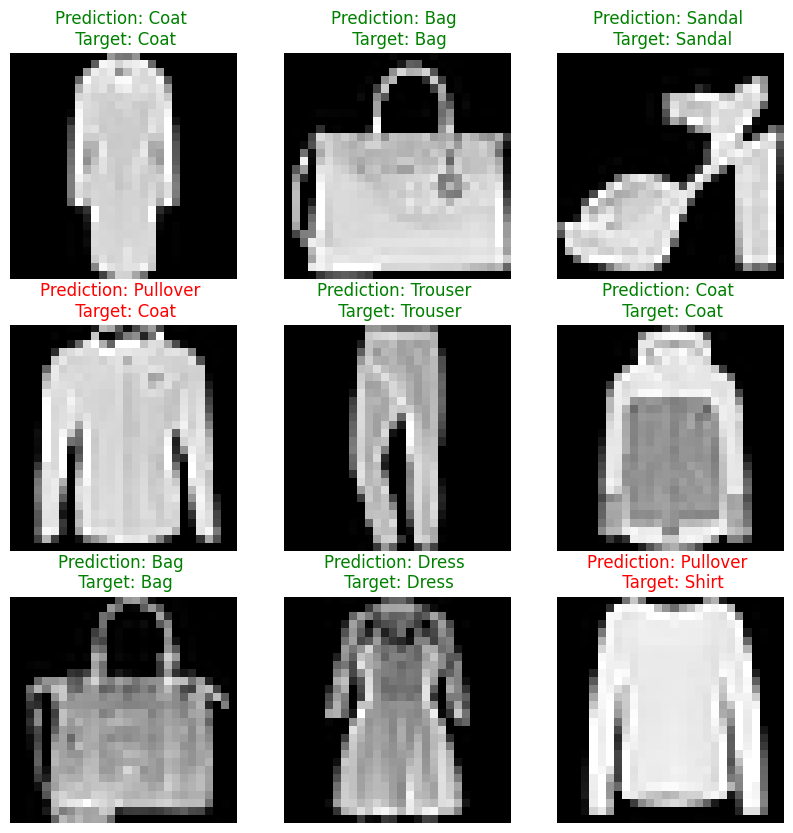

In [305]:
# Plot the predictions
plt.figure(figsize=(10, 10))
nrows = 3
ncols = 3

for i, sample in enumerate(test_samples):
    plt.subplot(nrows, ncols, i+1)
    
    # Plot the target image
    plt.imshow(sample.squeeze(), cmap="gray")

    # Get the predicted class name
    pred_label = class_names[pred_probs[i].argmax()]

    # Get the target class name
    target_class_name = class_names[test_label[i]]

    # Check if the prediction is correct
    if pred_label == target_class_name:
        plt.title(f"Prediction: {pred_label} \n Target: {target_class_name}", color="green")
    else:
        plt.title(f"Prediction: {pred_label} \n Target: {target_class_name}", color="red")

    plt.axis("off")

plt.show()


## 10. Making a confusion matrix

A cofusion matrix is a fantastic way to evaluate our model. It shows us how well our model is doing in terms of predicting the correct class. We can use the `sklearn` library to create a confusion matrix.

The way to make a cofusion matrix is:
1. Make predictions on the trained model using the test data.
2. Making a cofusion matrix `torchmetrics.ConfusionMatrix` - https://torchmetrics.readthedocs.io/en/v0.8.2/classification/confusion_matrix.html
3. Plot the confusion matrix using `mlxtend.plotting.plot_confusion_matrix()` - https://rasbt.github.io/mlxtend/user_guide/evaluate/confusion_matrix/

In [317]:
# Import tqdm.auto for progress bars
from tqdm.auto import tqdm

# 1. Make predictions on the test data
y_preds = []
model_2.eval()
with torch.inference_mode():
    for data, target in tqdm(test_dataloader, desc="Making predictions on test data..."):
        # Move the data to the device
        data, target = data.to(device), target.to(device)

       # Make predictions
        output = model_2(data)

        # Get the predicted class
        y_preds.append(output.argmax(dim=1).cpu())


Making predictions on test data...: 100%|██████████| 313/313 [00:03<00:00, 86.55it/s]


In [318]:
# Concatenate the predictions
y_preds_tensor = torch.cat(y_preds)
print(y_preds_tensor)

tensor([9, 2, 1,  ..., 8, 1, 5])


In [314]:
len(y_preds_tensor)

10000

In [326]:
from torchmetrics.classification import ConfusionMatrix


cofmat = ConfusionMatrix(task="multiclass", num_classes=len(class_names), )
cofmat(y_preds_tensor, test_data.targets)

tensor([[768,   0,  16,  34,   4,   1, 166,   0,  11,   0],
        [  1, 967,   0,  23,   2,   1,   1,   0,   5,   0],
        [  8,   1, 824,  10,  78,   0,  75,   0,   4,   0],
        [ 19,   7,   7, 894,  34,   0,  34,   0,   5,   0],
        [  0,   1, 123,  38, 736,   0,  94,   1,   7,   0],
        [  0,   0,   1,   0,   0, 967,   0,  23,   3,   6],
        [ 88,   1,  99,  36,  65,   0, 687,   1,  23,   0],
        [  0,   0,   0,   0,   0,  14,   0, 949,   4,  33],
        [  1,   2,   0,   6,   3,   3,   3,   1, 981,   0],
        [  1,   0,   0,   0,   0,   7,   0,  23,   1, 968]])

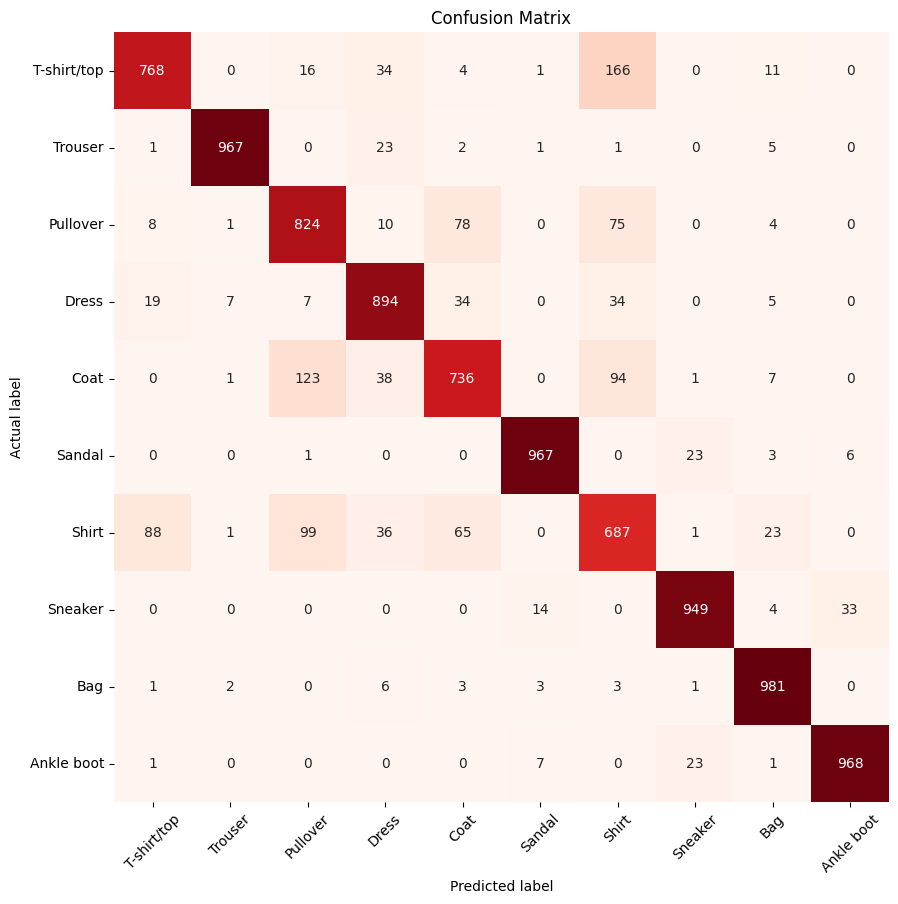

In [346]:
# Update class names
class_names = test_data.classes

# Plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
sns.heatmap(cofmat.compute().numpy(), annot=True, fmt="d", cmap="Reds", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted label")
plt.ylabel("Actual label")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)  # Incline the x-axis labels
plt.yticks(rotation=0)  # Incline the y-axis labels
plt.show()


## 11. Save and load the best performing model

In [344]:
from pathlib import Path

# Create a directory to save the model
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(exist_ok=True,
                parents=True)

# Create model save path
MODEL_NAME = "fashion_mnist_model_2.pt"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(model_2, MODEL_SAVE_PATH)

Saving model to: models/fashion_mnist_model_2.pt
